In [12]:
# setup
import os
import subprocess
import json
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
import numpy as np

class TestCase:
    def __init__(self,
                    width: int,
                    height: int,
                    frames: int,
                    sensor_radius: int,
                    body_radius: int):
        self.width = width
        self.height = height
        self.frames = frames
        self.sensor_radius = sensor_radius 
        self.body_radius = body_radius
        
def run_tests( rng_seed: int, path_to_output: str):
    for i, test_case in enumerate(test_cases):
        print(f"Running test case {i+1} of {len(test_cases)}")
        run_test_one_side(False, rng_seed, path_to_output, test_case)
        run_test_one_side(True, rng_seed, path_to_output, test_case)
        print(f"Test case {i+1} done")
def run_test_one_side(
        use_gpu,
        rng_seed,
        path_to_output,
        test_case):
        half_width = int(test_case.width // 2.0)
        half_height = int(test_case.height // 2.0)
        with open("run_config.json", "w") as f:
            f.write(f"""{{
                "bottom_left_x": -{half_width},
                "bottom_left_y": -{half_height},
                "top_right_x": {half_width},
                "top_right_y": {half_height},
                "sensor_radius": {test_case.sensor_radius},
                "body_radius": {test_case.body_radius},
                "rng_seed": {rng_seed},
                "num_frames_to_test": {test_case.frames},
                "use_gpu": {"true" if use_gpu else "false"},
                "path_to_output_json": "{path_to_output}"
            }}""")
        subprocess.run(["cargo", "run", "--release"], check=True)
        
def deduplicate_clusters(df, cluster_width=5000):
    df_sorted = df.sort_values('collisions_per_frame')
    current_cluster = 0
    cluster_labels = []
    current_cluster_start = df_sorted['collisions_per_frame'].iloc[0]
    for value in df_sorted['collisions_per_frame']:
        if value - current_cluster_start > cluster_width:
            current_cluster += 1
            current_cluster_start = value
        cluster_labels.append(current_cluster)
    
    df_sorted['cluster'] = cluster_labels
    result = df_sorted.loc[df_sorted.groupby('cluster')['frames'].idxmax()]
    result = result.drop('cluster', axis=1).sort_index()
    
    return result
def millions_formatter(x, pos):
    v = int(x/1000000)
    if v == 0:
        return f'0'
    return f'{int(x/1000000)} Million'
def thousands_formatter(x, pos):
    v = int(x/1000)
    if v == 0:
        return f'0'
    return f'{int(x/1000)}K'
    

In [4]:
# test cases

test_cases = [
    TestCase(
        width=3,
        height=3,
        frames=1000,
        sensor_radius=21,
        body_radius=3
    ),
    TestCase(
        width=12,
        height=12,
        frames=400,
        sensor_radius=21,
        body_radius=3
    ),
    TestCase(
        width=24,
        height=24,
        frames=200,
        sensor_radius=21,
        body_radius=3
    ),
    TestCase(
        width=40,
        height=40,
        frames=100,
        sensor_radius=21,
        body_radius=3
    ),
    TestCase(
        width=60,
        height=60,
        frames=20,
        sensor_radius=21,
        body_radius=3
    ),
    TestCase(
        width=80,
        height=80,
        frames=6,
        sensor_radius=21,
        body_radius=3
    ),
    TestCase(
        width=100,
        height=100,
        frames=4,
        sensor_radius=21,
        body_radius=3
    ),
    TestCase(
        width=120,
        height=120,
        frames=3,
        sensor_radius=21,
        body_radius=3
    ),
    TestCase(
        width=160,
        height=160,
        frames=3,
        sensor_radius=21,
        body_radius=3
    ),
     TestCase(
        width=18,
        height=18,
        frames=1000,
        sensor_radius=21,
        body_radius=3
    ),
      TestCase(
        width=13,
        height=13,
        frames=1500,
        sensor_radius=21,
        body_radius=3
    ),
       TestCase(
        width=15,
        height=15,
        frames=1400,
        sensor_radius=21,
        body_radius=3
    ),
        TestCase(
        width=16,
        height=16,
        frames=1700,
        sensor_radius=21,
        body_radius=3
    ),
        TestCase(
        width=17,
        height=17,
        frames=300,
        sensor_radius=21,
        body_radius=3
    ),
        TestCase(
        width=8,
        height=8,
        frames=3000,
        sensor_radius=21,
        body_radius=3
    ),
         TestCase(
        width=15,
        height=15,
        frames=300,
        sensor_radius=21,
        body_radius=3
    ),
         TestCase(
        width=16,
        height=16,
        frames=300,
        sensor_radius=21,
        body_radius=3
    ),
               TestCase(
        width=15,
        height=15,
        frames=5000,
        sensor_radius=21,
        body_radius=3
    ),
         TestCase(
        width=16,
        height=16,
        frames=5000,
        sensor_radius=21,
        body_radius=3
    ),
            TestCase(
        width=13,
        height=13,
        frames=4000,
        sensor_radius=5,
        body_radius=40
    ),
           TestCase(
        width=18,
        height=18,
        frames=2000,
        sensor_radius=5,
        body_radius=40
    ),
           TestCase(
        width=40,
        height=40,
        frames=5,
        sensor_radius=5,
        body_radius=40
    ),
            TestCase(
        width=9,
        height=9,
        frames=4000,
        sensor_radius=5,
        body_radius=40
    ),
            TestCase(
        width=10,
        height=10,
        frames=3500,
        sensor_radius=21,
        body_radius=3
    ),
                    TestCase(
        width=11,
        height=11,
        frames=3000,
        sensor_radius=21,
        body_radius=3
    ),
            TestCase(
        width=14,
        height=14,
        frames=2500,
        sensor_radius=21,
        body_radius=3
    ),
   
]

In [ ]:
# run
run_tests(1, "./output_from_script.json")

Running test case 1 of 26


In [7]:
# Get Results
results = json.load(open("./output_from_script.json"))

df = pd.DataFrame(results)
df_gpu = df[df["method"] == "Gpu"].copy()
df_cpu = df[df["method"] == "Cpu"].copy()
# Add the test case parameters
# gpu
df_gpu.loc[:, "width"] = [test_cases[i].width for i in range(len(test_cases))]
df_gpu.loc[:, "height"] = [test_cases[i].height for i in range(len(test_cases))]
df_gpu.loc[:, "frames"] = [test_cases[i].frames for i in range(len(test_cases))]
df_gpu.loc[:, "sensor_radius"] = [test_cases[i].sensor_radius for i in range(len(test_cases))]
df_gpu.loc[:, "body_radius"] = [test_cases[i].body_radius for i in range(len(test_cases))]
# cpu
df_cpu.loc[:, "width"] = [test_cases[i].width for i in range(len(test_cases))]
df_cpu.loc[:, "height"] = [test_cases[i].height for i in range(len(test_cases))]
df_cpu.loc[:, "frames"] = [test_cases[i].frames for i in range(len(test_cases))]
df_cpu.loc[:, "sensor_radius"] = [test_cases[i].sensor_radius for i in range(len(test_cases))]
df_cpu.loc[:, "body_radius"] = [test_cases[i].body_radius for i in range(len(test_cases))]

# calculate percentage difference in average frame time
df_gpu["pct_diff"] = [0 for i in range(len(df_gpu))]
for i in range(len(df_gpu)):
    gpu_val = df_gpu["avg_frame_time"].iloc[i]
    cpu_val = df_cpu["avg_frame_time"].iloc[i]
    x = df_gpu["collisions_per_frame"].iloc[i]
    pct_diff = -1* ((gpu_val - cpu_val) / cpu_val) * 100
    df_gpu["pct_diff"].iloc[i] = pct_diff
    
    


C:\Users\sheld\AppData\Local\Temp\ipykernel_8676\3731697705.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gpu["pct_diff"].iloc[i] = pct_diff


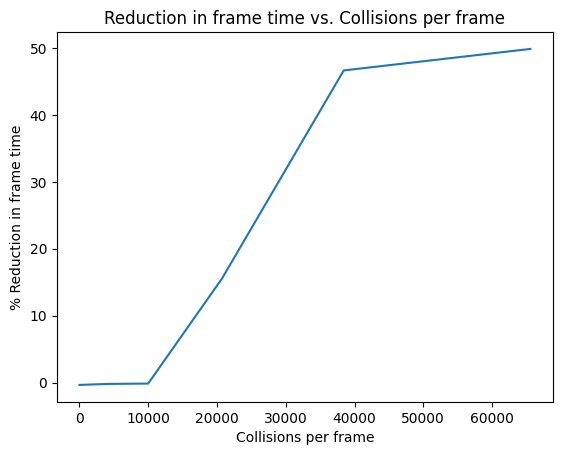

In [9]:
# Plot % difference
max_cpf = 100000 # for example


df_gpu_filtered = df_gpu[df_gpu["collisions_per_frame"] < max_cpf]
df_gpu_filtered_deduped = deduplicate_clusters(df_gpu_filtered, cluster_width=500)
df_gpu_filtered_deduped = df_gpu_filtered_deduped.sort_values('collisions_per_frame')
plt.figure()
plt.plot(df_gpu_filtered_deduped["collisions_per_frame"], df_gpu_filtered_deduped["pct_diff"], label="Gpu")
# plt.xscale('log')
plt.xlabel("Collisions per frame")
plt.ylabel("% Reduction in frame time")
plt.title("Reduction in frame time vs. Collisions per frame")
plt.show()



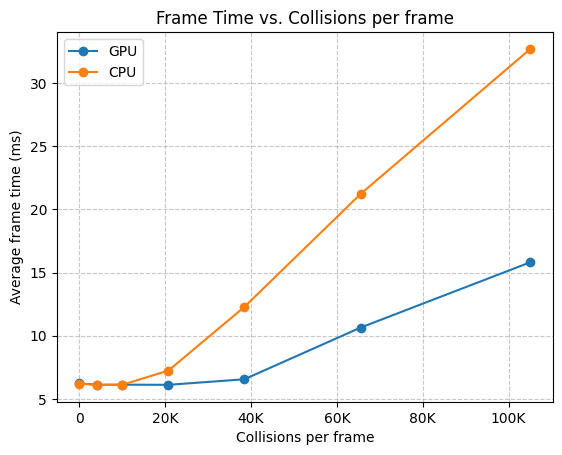

In [17]:
#Plot Frame Time comparison
df_gpu_deduped = deduplicate_clusters(df_gpu, cluster_width=1000)
df_cpu_deduped = deduplicate_clusters(df_cpu, cluster_width=1000)
max_cpf = 200000 
df_gpu_deduped = df_gpu_deduped[df_gpu_deduped["collisions_per_frame"] < max_cpf]
df_cpu_deduped = df_cpu_deduped[df_cpu_deduped["collisions_per_frame"] < max_cpf]
df_gpu_deduped = df_gpu_deduped.sort_values('collisions_per_frame')
df_cpu_deduped = df_cpu_deduped.sort_values('collisions_per_frame')


gpu_line = plt.plot(df_gpu_deduped["collisions_per_frame"], df_gpu_deduped["avg_frame_time"], label="GPU", marker='o')
cpu_line = plt.plot(df_cpu_deduped["collisions_per_frame"], df_cpu_deduped["avg_frame_time"], label="CPU", marker='o')

if max_cpf > 9000000:
    plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))
else:
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.xlabel("Collisions per frame")
plt.ylabel("Average frame time (ms)")
plt.legend()
plt.title("Frame Time vs. Collisions per frame")
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()